In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  2 13:35:00 2024

@author: laserglaciers
"""

from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import string

In [6]:
df_path = '../data/tides/abs_vel_d8_date2_grounded_floating_gz.pkl'
tides_path = '../data/tides/tmd_modeled_tide_all_components-2015-2023.pkl'

## need to interpolate tides to match linear
df = pd.read_pickle(df_path)

tb_along_d8_18 = df.loc[:pd.to_datetime('2019')]
tb_along_d8_19 = df.loc[pd.to_datetime('2019'):]


tide_df = pd.read_pickle(tides_path)

ynew_18 = np.interp(tb_along_d8_18.index, tide_df.index, tide_df.values)
ynew_19 = np.interp(tb_along_d8_19.index, tide_df.index, tide_df.values)

tide_df_interp_18 = pd.Series(data=ynew_18,index=tb_along_d8_18.index)
tide_df_interp_19 = pd.Series(data=ynew_19,index=tb_along_d8_19.index)


#fill missing data 
# tb_along_d8_19 = tb_along_d8_19.interpolate(method='cubic', order=3).dropna()


label_dict = {'fontsize': 20}
labelsize = 17
alphabet = list(string.ascii_lowercase)
tab_blue_rgb = plt.get_cmap("tab10")(0)

tidal_height_range = (-2,2)


tab_orange_rgb = plt.get_cmap("tab10")(1)  # Index 1 corresponds to orange
# Darken the color by multiplying each RGB value by 0.8
darker_orange = tuple(c * 0.8 for c in tab_orange_rgb[:3])
legend_dict = {'loc':'upper right',
               'ncol':2, 
               'fontsize':'x-large'}

In [7]:
# https://jinhyuncheong.com/jekyll/update/2017/12/10/Timeseries_synchrony_tutorial_and_simulations.html
# Learned from this tutorial
def get_triangle(df,k=0):
    '''
    This function grabs the upper triangle of a correlation matrix
    by masking out the bottom triangle (tril) and returns the values.

    df: pandas correlation matrix
    '''
    x = np.hstack(df.mask(np.tril(np.ones(df.shape),k=k).astype(bool)).values.tolist())
    x = x[~np.isnan(x)]
    return x  

def rolling_correlation(data, wrap=False, *args, **kwargs):
    '''
    Intersubject rolling correlation.
    Data is dataframe with observations in rows, subjects in columns.
    Calculates pairwise rolling correlation at each time.
    Grabs the upper triangle, at each timepoints returns dataframe with
    observation in rows and pairs of subjects in columns.
    *args:
        window: window size of rolling corr in samples
        center: whether to center result (Default: False, so correlation values are listed on the right.)
    '''
    data_len = data.shape[0]
    half_data_len = int(data.shape[0]/2)
    start_len = data.iloc[half_data_len:].shape[0]
    if wrap:
        data = pd.concat([data.iloc[half_data_len:],data,data.iloc[:half_data_len]],axis=0).reset_index(drop=True)
    _rolling = data.rolling(*args, **kwargs).corr()       
    rs=[]
    for i in np.arange(0,data.shape[0]):
        rs.append(get_triangle(_rolling.loc[i]))
    rs = pd.DataFrame(rs)   
    rs = rs.iloc[start_len:start_len+data_len].reset_index(drop=True)
    return rs 

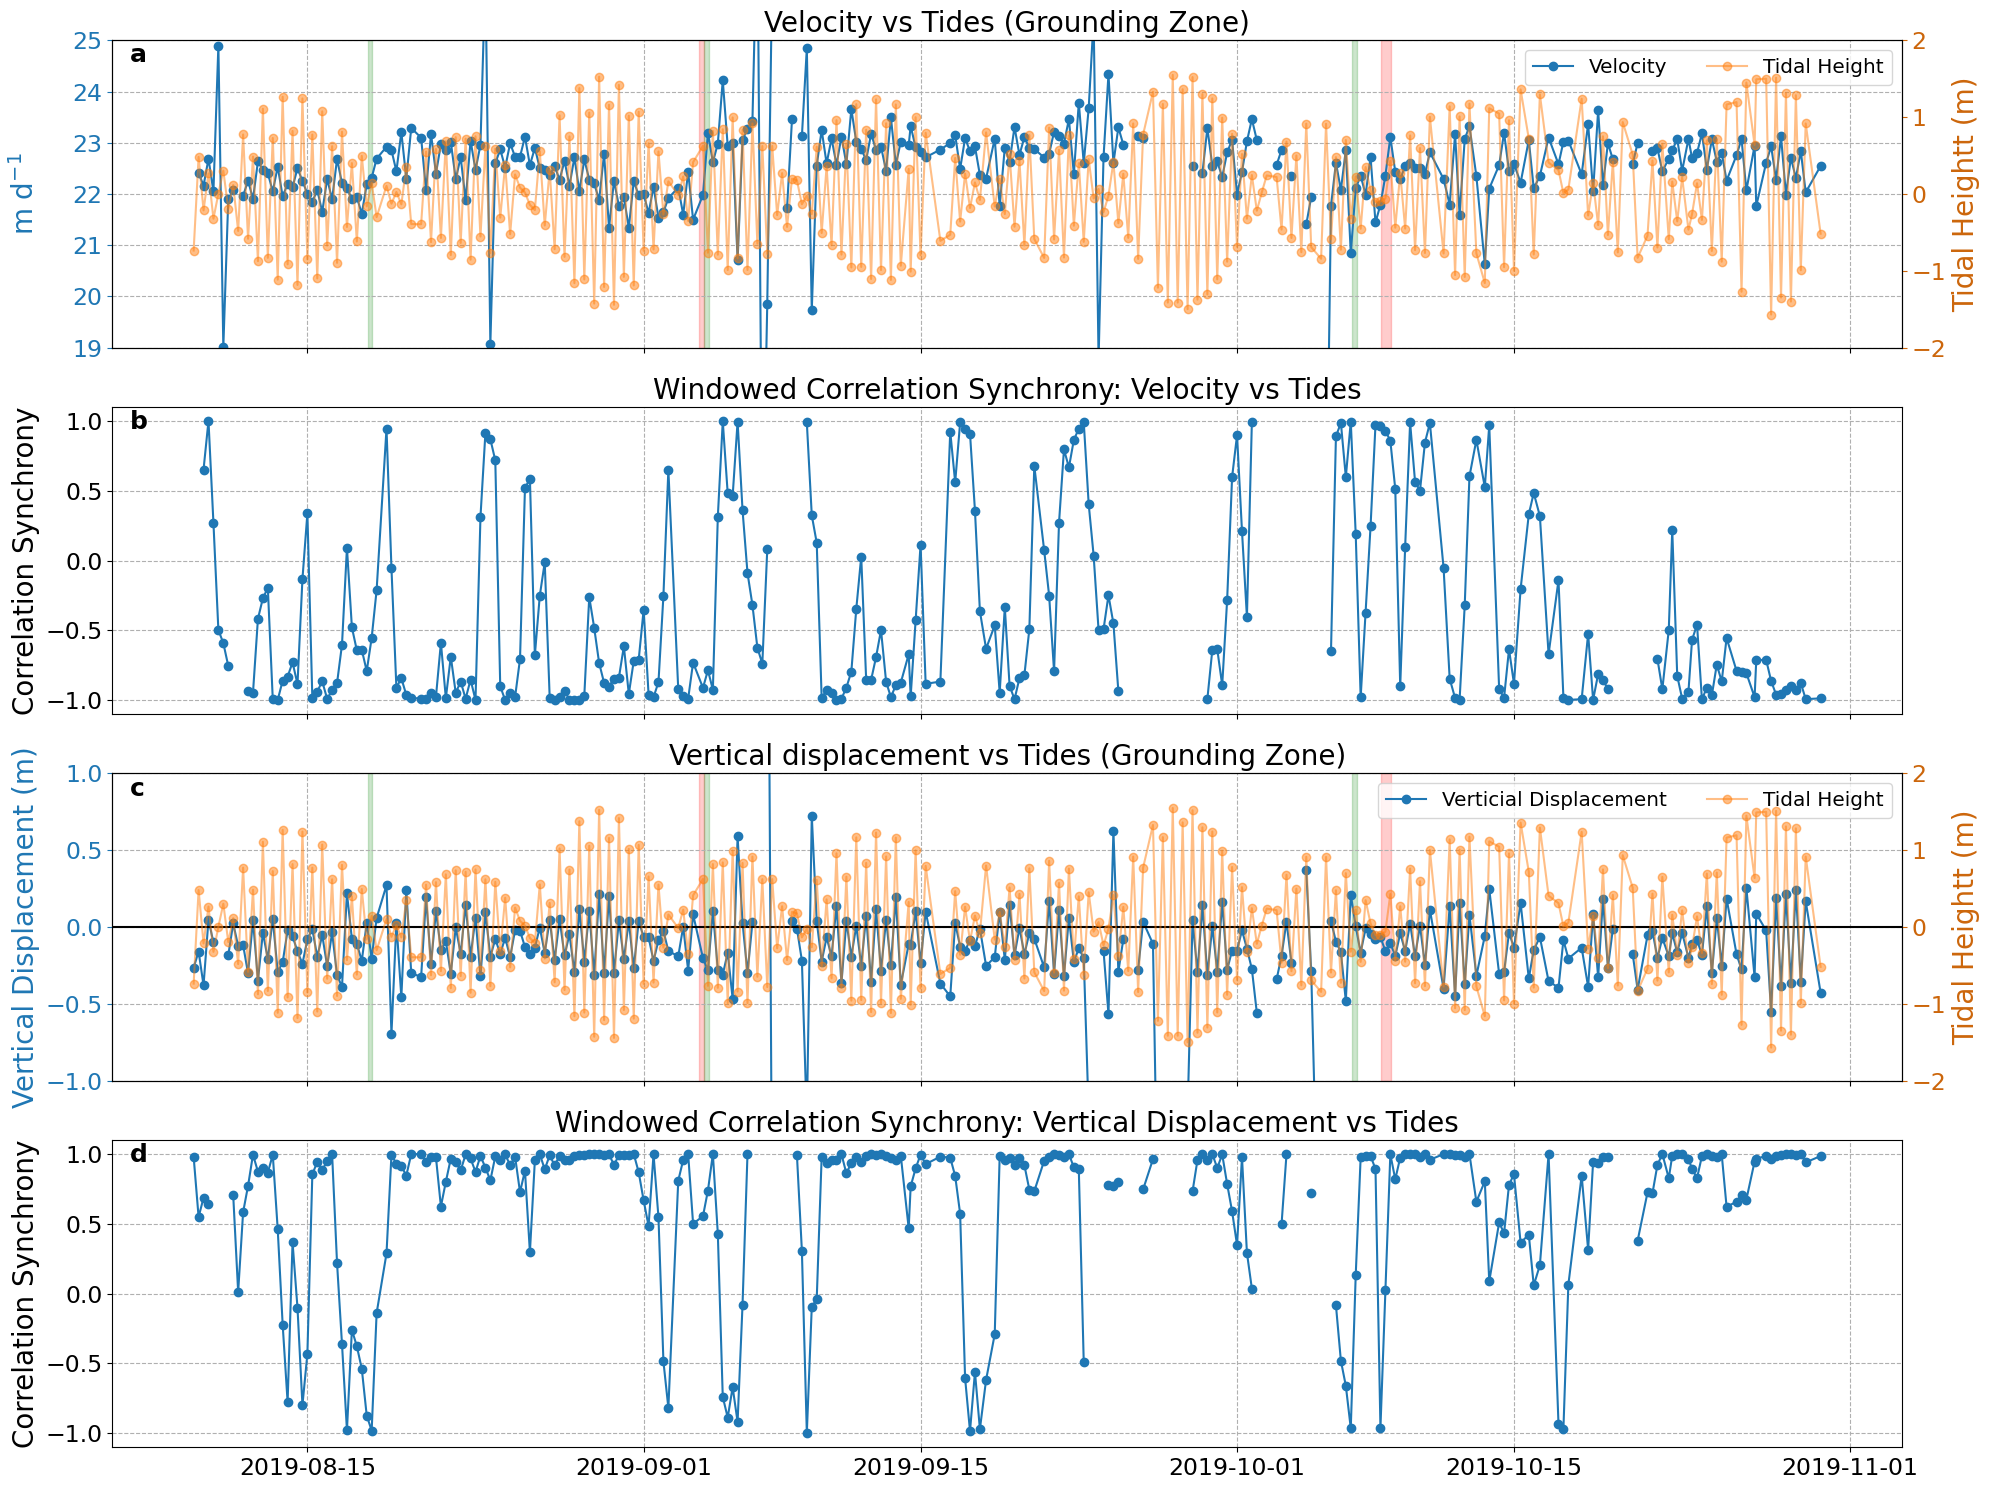

In [9]:
window_size = 3
y1 = tb_along_d8_19.grounding_zone.values
dz_i = tb_along_d8_19.index[:-41] # dates of choice. -41 is when the 24 hour scans start
y2 = tide_df_interp_19.loc[dz_i[0]:]
y2_filter = tide_df_interp_19.loc[dz_i[0]:dz_i[-1]].values

window=10
al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)

f,ax = plt.subplots(4,1,figsize=(20,15),sharex=True)


ax2 = ax[0].twinx()
force_plot = ax[0].plot(tb_along_d8_19.index[:-41], y1[:-41],'o-', color='tab:blue',label='Velocity')
tide_plot = ax2.plot(tb_along_d8_19.index[:-41], y2_filter, 'o-',color='tab:orange',label='Tidal Height', alpha=0.5)
# added these three lines
lns = force_plot+tide_plot
labs = [l.get_label() for l in lns]
# ax[0].legend(lns, labs, loc=0)
# ax[0].legend(lns, labs, bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].legend(lns, labs, **legend_dict)
ax[0].axhline(0,color='k')
ax[0].set_ylim(19,25)
ax[0].set_title('Velocity vs Tides (Grounding Zone)', **label_dict)
# ax[0].set_ylabel('m d$^{-1}$', labelpad=25,**label_dict)
ax[0].set_ylabel('m d$^{-1}$', **label_dict)

ax2.set_ylabel('Tidal Heightt (m)',**label_dict)
ax2.set_ylim(tidal_height_range)

ax[0].yaxis.label.set_color('tab:blue')
ax[0].tick_params(axis='y', colors='tab:blue')

ax2.yaxis.label.set_color(darker_orange)
ax2.tick_params(axis='y', colors=darker_orange)


ax[0].tick_params(axis='both', labelsize = labelsize)
ax[1].tick_params(axis='both', labelsize = labelsize)
ax2.tick_params(axis='both', labelsize = labelsize)
ax[0].grid(True, linestyle='--')

window_corr_synchrony = rolling_correlation(data=pd.DataFrame({'y1':y1,'y2':y2}),wrap=True,window=window_size,center=True)
# # window_corr_synchrony.plot(ax=ax[1],legend=False)
ax[1].plot(tb_along_d8_19.index[:-41], window_corr_synchrony.values[:-41],'o-')
# ax[1].legend().set_visible(False)
ax[1].set(ylim=[-1.1,1.1])
ax[1].set_title('Windowed Correlation Synchrony: Velocity vs Tides', **label_dict)
ax[1].set_ylabel('Correlation Synchrony', **label_dict)
# ax[1].set_xlabel('Time', **label_dict)
ax[1].grid(True, linestyle='--')


flexure_data_path = '../data/tides/flexure_vs_non-flexure_calving.csv'
flexure_data = pd.read_csv(flexure_data_path ,parse_dates=(['first_scan', 'last_scan']))
msk = (flexure_data['first_scan'] >= tb_along_d8_19.index[0]) & (flexure_data['first_scan'] <= tb_along_d8_19.index[-1])
flexure_data = flexure_data[msk]


for row in flexure_data.iterrows():
    nan_mask = row[1].notnull()
    
    if (nan_mask.first_scan == True) and (nan_mask.last_scan == True):
        
        if row[1]['type'] == 'flexure':
            vspan_c = 'r'
        else:
            vspan_c = 'g'
        first_scan_date = row[1]['first_scan']
        last_scan_date = row[1]['last_scan']
    ax[0].axvspan(first_scan_date,last_scan_date,color=vspan_c,alpha=0.2)




# vertical displacement 
zdf_path = '../data/tides/z_disp_d3_date2_grounded_floating_gz.pkl'
zdf = pd.read_pickle(zdf_path)

zdf_d3_18 = zdf.loc[:pd.to_datetime('2019')]
zdf_d3_19 = zdf.loc[pd.to_datetime('2019'):]
y3 = zdf_d3_19.grounding_zone.values
y4 = tide_df_interp_19.values

ax3 = ax[2].twinx()
z_disp_plot = ax[2].plot(zdf_d3_19.index[:-41], y3[:-41],'o-', color='tab:blue',label='Verticial Displacement')
tide_plot2 = ax3.plot(zdf_d3_19.index[:-41], y4[:-41], 'o-',color='tab:orange',label='Tidal Height', alpha=0.5)

# added these three lines
lns2 = z_disp_plot+tide_plot2
labs2 = [l.get_label() for l in lns2]
# ax[0].legend(lns, labs, loc=0)
# ax[0].legend(lns, labs, bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[2].legend(lns2, labs2, **legend_dict)
ax[2].axhline(0,color='k')
ax[2].set_ylim(-1,1)
ax[2].set_title('Vertical displacement vs Tides (Grounding Zone)', **label_dict)
ax[2].set_ylabel('Vertical Displacement (m)', **label_dict)

ax3.set_ylabel('Tidal Heightt (m)',**label_dict)
ax3.set_ylim(tidal_height_range)

ax[2].yaxis.label.set_color('tab:blue')
ax[2].tick_params(axis='y', colors='tab:blue')

ax3.yaxis.label.set_color(darker_orange)
ax3.tick_params(axis='y', colors=darker_orange)


ax[2].tick_params(axis='both', labelsize = labelsize)
ax[2].grid(True, linestyle='--')
ax[3].tick_params(axis='both', labelsize = labelsize)
ax3.tick_params(axis='both', labelsize = labelsize)


window_corr_synchrony_2 = rolling_correlation(data=pd.DataFrame({'y3':y3,'y4':y4}),wrap=True,window=window_size,center=True)
# # window_corr_synchrony.plot(ax=ax[1],legend=False)
ax[3].plot(zdf_d3_19.index[:-41], window_corr_synchrony_2.values[:-41],'o-')
ax[3].set(ylim=[-1.1,1.1])
ax[3].set_title('Windowed Correlation Synchrony: Vertical Displacement vs Tides', **label_dict)
ax[3].set_ylabel('Correlation Synchrony', **label_dict)
# ax[3].set_xlabel('Time', **label_dict)
ax[3].grid(True, linestyle='--')


text_dict = {'fontsize':18,
             'fontweight': 'bold'}
ax = ax.flatten()
for i,axis in enumerate(ax):
    
    text_label = axis.text(.01, .99, alphabet[i], ha='left', va='top', transform=axis.transAxes, **text_dict)

for row in flexure_data.iterrows():
    nan_mask = row[1].notnull()
    
    if (nan_mask.first_scan == True) and (nan_mask.last_scan == True):
        
        if row[1]['type'] == 'flexure':
            vspan_c = 'r'
        else:
            vspan_c = 'g'
        first_scan_date = row[1]['first_scan']
        last_scan_date = row[1]['last_scan']
    ax[2].axvspan(first_scan_date,last_scan_date,color=vspan_c,alpha=0.2)

f.align_ylabels(ax)
plt.tight_layout()
